### per_order and per_client

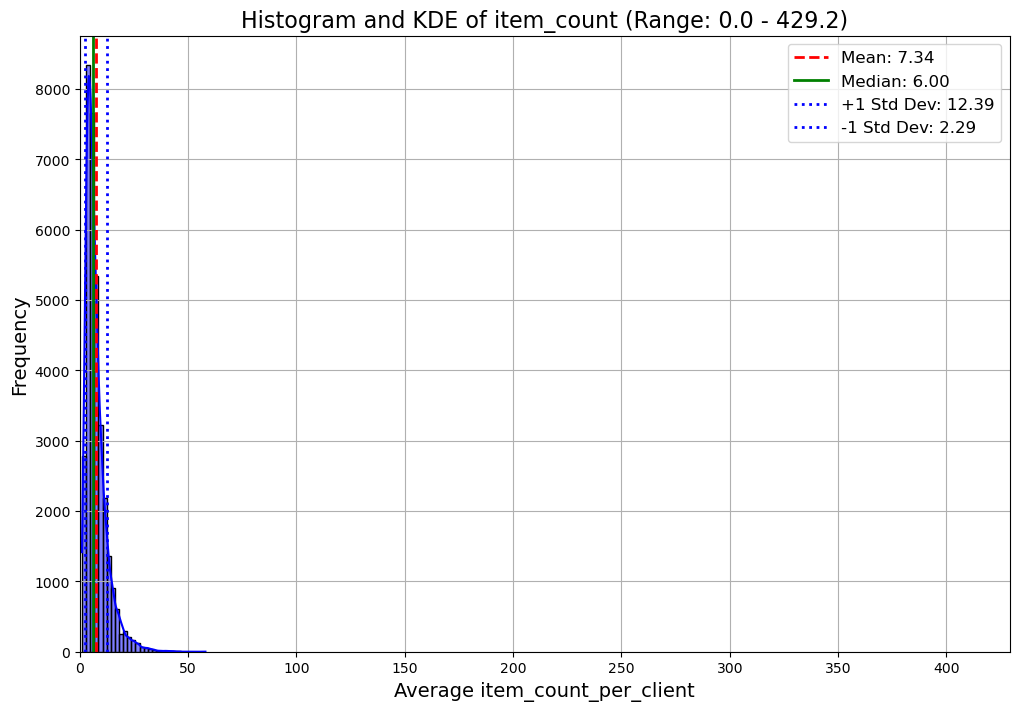

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output

np.seterr(divide='ignore', invalid='ignore')

# Load the CSV file
df = pd.read_csv('/Users/irem.aslan/Downloads/ltr_financial_metrics (1).csv', index_col=0)

# Check column names
print("Column Names:", df.columns)

# Columns to ignore
ignore_columns = ['client_id', 'order_id', 'status', 'domaintype', 'successful_order', 'createdat', 'checkout_date', 'checkoutdatel', 'first_experiment_view']

# Filter outliers and negative values for 'basket_value' column
df = df[(df['basket_value'] >= 0) & (df['basket_value'] <= df['basket_value'].quantile(0.99))]

# Check min and max values
min_value = df['basket_value'].min()
max_value = df['basket_value'].max()
print(f"Minimum basket_value: {min_value}")
print(f"Maximum basket_value: {max_value}")

def per_client_statistics(df, ignore_columns):
    columns_to_consider = [col for col in df.columns if col not in ignore_columns]
    try:
        data = df[df['successful_order'] == 1].copy()
    except KeyError:
        data = df.copy()
    numeric_columns = data[columns_to_consider].select_dtypes(include=[np.number]).columns.tolist()
    result = data.groupby('client_id')[numeric_columns].mean().reset_index()
    return result

def per_order_statistics(df, ignore_columns):
    columns_to_consider = [col for col in df.columns if col not in ignore_columns]
    try:
        data = df[df['successful_order'] == 1].copy()
    except KeyError:
        data = df.copy()
    numeric_columns = data[columns_to_consider].select_dtypes(include=[np.number]).columns.tolist()
    result = data.groupby('order_id')[numeric_columns].mean().reset_index()
    return result

def plot_distribution(column, start, end, analysis_type):
    clear_output(wait=True)
    display(ui)
    
    if analysis_type == 'Per Client':
        data = per_client_result[(per_client_result[column] >= start) & (per_client_result[column] <= end)][column]
        xlabel = f'Average {column}_per_client'
    elif analysis_type == 'Per Order':
        data = per_order_result[(per_order_result[column] >= start) & (per_order_result[column] <= end)][column]
        xlabel = f'Average {column}_per_order'
        
    if data.empty:
        print("No valid data in the selected range.")
        return
    
    plt.figure(figsize=(12, 8))
    sns.histplot(data, kde=True, color='blue', bins=30)
    
    mean_val = data.mean()
    median_val = data.median()
    std_val = data.std()
    plus_sd = mean_val + std_val
    minus_sd = mean_val - std_val
    
    plt.title(f'Histogram and KDE of {column} (Range: {start:.1f} - {end:.1f})', fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xlim(start, end)
    
    plt.axvline(mean_val, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='g', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')
    plt.axvline(plus_sd, color='b', linestyle=':', linewidth=2, label=f'+1 Std Dev: {plus_sd:.2f}')
    plt.axvline(minus_sd, color='b', linestyle=':', linewidth=2, label=f'-1 Std Dev: {minus_sd:.2f}')
    
    plt.legend(loc='upper right', fontsize=12)
    plt.grid(True)
    plt.show()

per_client_result = per_client_statistics(df, ignore_columns)
per_order_result = per_order_statistics(df, ignore_columns)

sorted_columns = sorted(per_client_result.columns[1:])

analysis_type_dropdown = widgets.Dropdown(
    options=['Per Client', 'Per Order'],
    description='Analysis Type:',
    disabled=False,
)

column_dropdown = widgets.Dropdown(
    options=sorted_columns,
    description='Column:',
    disabled=False,
)

x_min_slider = widgets.FloatSlider(
    value=per_client_result[per_client_result.columns[1]].min(),
    min=per_client_result[per_client_result.columns[1]].min(),
    max=per_client_result[per_client_result.columns[1]].max(),
    step=0.1,
    description='Start',
    continuous_update=True
)

x_max_slider = widgets.FloatSlider(
    value=per_client_result[per_client_result.columns[1]].max(),
    min=per_client_result[per_client_result.columns[1]].min(),
    max=per_client_result[per_client_result.columns[1]].max(),
    step=0.1,
    description='End',
    continuous_update=True
)

def update_slider_ranges(change):
    col = column_dropdown.value
    if analysis_type_dropdown.value == 'Per Client':
        min_val = per_client_result[col].min()
        max_val = per_client_result[col].max()
    elif analysis_type_dropdown.value == 'Per Order':
        min_val = per_order_result[col].min()
        max_val = per_order_result[col].max()
    
    x_min_slider.min = min_val
    x_min_slider.max = max_val
    x_min_slider.value = min_val
    
    x_max_slider.min = min_val
    x_max_slider.max = max_val
    x_max_slider.value = max_val

def on_change(change):
    if column_dropdown.value and x_min_slider.value <= x_max_slider.value:
        plot_distribution(column_dropdown.value, x_min_slider.value, x_max_slider.value, analysis_type_dropdown.value)

analysis_type_dropdown.observe(update_slider_ranges, names='value')
column_dropdown.observe(update_slider_ranges, names='value')

x_min_slider.observe(on_change, names='value')
x_max_slider.observe(on_change, names='value')

ui = widgets.VBox([analysis_type_dropdown, column_dropdown, x_min_slider, x_max_slider])

display(ui)

if not per_client_result.columns[1:].empty:
    update_slider_ranges({'new': per_client_result.columns[1]})
    plot_distribution(per_client_result.columns[1], x_min_slider.value, x_max_slider.value, 'Per Client')
